# Created using SageMaker. Ran into problems installing MXnet and GluonCV on my machine. Seemed to be a problem of imcompatibility with other packages such as numpy.

### Source: https://cv.gluon.ai/build/examples_datasets/detection_custom.html

In [3]:
pip install gluoncv

     |████████████████████████████████| 1.3 MB 17.1 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os, zipfile
import mxnet as mx
import numpy as np
from matplotlib import pyplot as plt
from gluoncv import utils

In [5]:
import gluoncv

In [6]:
mx.__version__

'1.7.0'

In [7]:
gluoncv.__version__

'0.11.0'

100%|██████████| 160/160 [00:00<00:00, 29157.48KB/s]


(576, 768, 3)


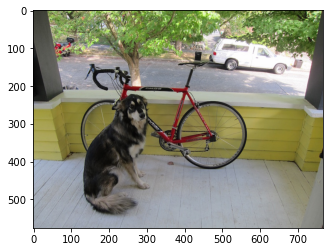

In [6]:
im_fname = utils.download('https://github.com/dmlc/web-data/blob/master/' +
                          'gluoncv/datasets/dog.jpg?raw=true',
                          path='dog.jpg')
img = mx.image.imread(im_fname)
ax = utils.viz.plot_image(img)
print(img.shape)
plt.show()

# Manual labelling

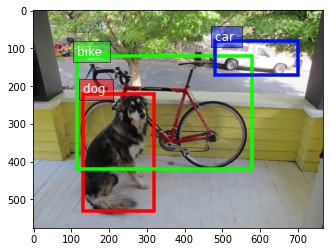

In [7]:
dog_label = [130, 220, 320, 530]
bike_label = [115, 120, 580, 420]
car_label = [480, 80, 700, 170]
all_boxes = np.array([dog_label, bike_label, car_label])
all_ids = np.array([0, 1, 2])
class_names = ['dog', 'bike', 'car']

# see how it looks by rendering the boxes into image
ax = utils.viz.plot_bbox(img, all_boxes, labels=all_ids, class_names=class_names)
plt.show()

# Creating LST label file

In [8]:
def write_line(img_path, im_shape, boxes, ids, idx):
    h, w, c = im_shape
    # for header, we use minimal length 2, plus width and height
    # with A: 4, B: 5, C: width, D: height
    A = 4
    B = 5
    C = w
    D = h
    # concat id and bboxes
    labels = np.hstack((ids.reshape(-1, 1), boxes)).astype('float')
    # normalized bboxes (recommanded)
    labels[:, (1, 3)] /= float(w)
    labels[:, (2, 4)] /= float(h)
    # flatten
    labels = labels.flatten().tolist()
    str_idx = [str(idx)]
    str_header = [str(x) for x in [A, B, C, D]]
    str_labels = [str(x) for x in labels]
    str_path = [img_path]
    line = '\t'.join(str_idx + str_header + str_labels + str_path) + '\n'
    return line

In [9]:
with open('val.lst', 'w') as fw:
    for i in range(4):
        line = write_line('dog.jpg', img.shape, all_boxes, all_ids, i)
        print(line)
        fw.write(line)

0	4	5	768	576	0.0	0.16927083333333334	0.3819444444444444	0.4166666666666667	0.9201388888888888	1.0	0.14973958333333334	0.20833333333333334	0.7552083333333334	0.7291666666666666	2.0	0.625	0.1388888888888889	0.9114583333333334	0.2951388888888889	dog.jpg

1	4	5	768	576	0.0	0.16927083333333334	0.3819444444444444	0.4166666666666667	0.9201388888888888	1.0	0.14973958333333334	0.20833333333333334	0.7552083333333334	0.7291666666666666	2.0	0.625	0.1388888888888889	0.9114583333333334	0.2951388888888889	dog.jpg

2	4	5	768	576	0.0	0.16927083333333334	0.3819444444444444	0.4166666666666667	0.9201388888888888	1.0	0.14973958333333334	0.20833333333333334	0.7552083333333334	0.7291666666666666	2.0	0.625	0.1388888888888889	0.9114583333333334	0.2951388888888889	dog.jpg

3	4	5	768	576	0.0	0.16927083333333334	0.3819444444444444	0.4166666666666667	0.9201388888888888	1.0	0.14973958333333334	0.20833333333333334	0.7552083333333334	0.7291666666666666	2.0	0.625	0.1388888888888889	0.9114583333333334	0.29513888888888

# Adapting PASCAL VOC annotation format to GluonCV LST format

In [10]:
fname = utils.download('https://github.com/dmlc/web-data/blob/master/gluoncv/datasets/VOCtemplate.zip?raw=true', 'VOCtemplate.zip')
with zipfile.ZipFile(fname) as zf:
    zf.extractall('.')

100%|██████████| 79/79 [00:00<00:00, 17714.52KB/s]


In [11]:
with open('VOCtemplate/VOC2018/Annotations/000001.xml', 'r') as fid:
    print(fid.read())

<annotation>
	<filename>000001.jpg</filename>
	<size>
		<width>353</width>
		<height>500</height>
		<depth>3</depth>
	</size>
	<object>
		<name>dog</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>48</xmin>
			<ymin>240</ymin>
			<xmax>195</xmax>
			<ymax>371</ymax>
		</bndbox>
	</object>
	<object>
		<name>person</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>8</xmin>
			<ymin>12</ymin>
			<xmax>352</xmax>
			<ymax>498</ymax>
		</bndbox>
	</object>
</annotation>



In [8]:
from gluoncv.data import VOCDetection
class VOCLike(VOCDetection):
    CLASSES = ['person', 'dog']
    def __init__(self, root, splits, transform=None, index_map=None, preload_label=True):
        super(VOCLike, self).__init__(root, splits, transform, index_map, preload_label)

dataset = VOCLike(root='VOCtemplate', splits=((2018, 'train'),))
print('length of dataset:', len(dataset))
print('label example:')
print(dataset[0][1])

#GluonCV swaps bounding boxes to columns 0-3 by default

length of dataset: 1
label example:
[[ 47. 239. 194. 370.   1.   0.]
 [  7.  11. 351. 497.   0.   0.]]


## Need to remove the last column of zeros which represent difficulty of the image since it is unnecessary for the LST file

In [52]:
clean_boxes = np.zeros((1,5))
clean_boxes

array([[0., 0., 0., 0., 0.]])

In [53]:
i = 0
while i < len(dataset[0][1]):
    clean_boxes = np.append(clean_boxes, [np.delete(dataset[0][1][i], [5])], axis = 0)
    print(clean_boxes)
    i += 1

[[  0.   0.   0.   0.   0.]
 [ 47. 239. 194. 370.   1.]]
[[  0.   0.   0.   0.   0.]
 [ 47. 239. 194. 370.   1.]
 [  7.  11. 351. 497.   0.]]


In [55]:
clean_boxes[0]

array([0., 0., 0., 0., 0.])

In [56]:
np.delete(clean_boxes, [0], axis = 0)

array([[ 47., 239., 194., 370.,   1.],
       [  7.,  11., 351., 497.,   0.]])

In [57]:
clean_boxes = np.delete(clean_boxes, [0], axis = 0)
clean_boxes

array([[ 47., 239., 194., 370.,   1.],
       [  7.,  11., 351., 497.,   0.]])

# Try to mannually label the image (Note: format of annotation for this manual labelling is not the same as the LST format. The class label is not in the bbox array)

In [58]:
im_fname = './VOCtemplate/VOC2018/JPEGImages/000001.jpg'

(500, 353, 3)


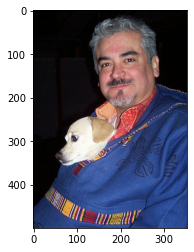

In [59]:
img = mx.image.imread(im_fname)
ax = utils.viz.plot_image(img)
print(img.shape)
plt.show()

In [63]:
annot_boxes = np.zeros((1,4))
annot_boxes

array([[0., 0., 0., 0.]])

In [64]:
i = 0
while i < len(dataset[0][1]):
    annot_boxes = np.append(annot_boxes, [np.delete(dataset[0][1][i], [4, 5])], axis = 0)
    print(annot_boxes)
    i += 1

[[  0.   0.   0.   0.]
 [ 47. 239. 194. 370.]]
[[  0.   0.   0.   0.]
 [ 47. 239. 194. 370.]
 [  7.  11. 351. 497.]]


In [68]:
annot_boxes = np.delete(annot_boxes, [0], axis = 0)

In [69]:
annot_boxes

array([[ 47., 239., 194., 370.],
       [  7.,  11., 351., 497.]])

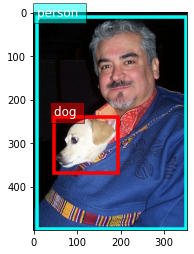

In [71]:
all_boxes = annot_boxes
all_ids = np.array([0, 1])
class_names = ['dog', 'person']

# see how it looks by rendering the boxes into image
ax = utils.viz.plot_bbox(img, all_boxes, labels=all_ids, class_names=class_names)
plt.show()